In [ ]:

# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
!pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
!pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
!pip install python-bcb==0.3.3

# Foi preciso dar upgrade para rodar os imports
!pip install --upgrade scikit-learn

In [ ]:
## 1. Importação de Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
import yfinance as yf
from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [ ]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # controla aleatoriedade interna do interpretador Python
  random.seed(seed) # controla aleatoriedade da biblioteca random
  np.random.seed(seed) # controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

In [ ]:
## 3. Coleta dos Dados

# Tempo inicial de compilação
_start_time = time.time()

# Datas de início e fim das features
start = '2016-01-01'
end = '2025-06-25'

# Dados da VALE3 (Close e Volume)
vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
vale.columns = ['Close_VALE3', 'Volume_VALE3'] # renomeia a coluna

# Dólar
dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index() # faz com que Date deixe de ser index e passe a ser uma coluna junto ao Close_Dolar
dolar['Date'] = pd.to_datetime(dolar['Date']) # muda o type da coluna Date para Datetime para ficar igual as demais variáveis
dolar.set_index('Date', inplace=True) # retorna Date para index, pois é assim que as demais variáveis estão

# Petróleo (WTI) pelo Yahoo Finance
petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
petroleo.columns = ['Close_Petroleo']

# Ibovespa
ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
ibov.columns = ['Close_Ibovespa']

# Minério de Ferro (supondo índice internacional)
minerio = yf.download('RIO', start=start, end=end)[['Close']] # mineradora Rio Tinto
minerio.columns = ['Close_Minerio']

/tmp/ipython-input-40-4199294367.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-40-4199294367.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-40-4199294367.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-40-4199294367.py:28: FutureWarning: YF.download() has changed argument auto_adj

In [ ]:
## 4. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
df = vale.copy() # cria uma cópia do dataframe para ir dando o merge
df = df.merge(dolar, left_index=True, right_index=True, how='left') # junta os dados ao dataframe principal a partir do index (date)
df = df.merge(petroleo, left_index=True, right_index=True, how='left')
df = df.merge(ibov, left_index=True, right_index=True, how='left')
df = df.merge(minerio, left_index=True, right_index=True, how='left')

# Remover valores nulos
df.dropna(inplace=True)

In [ ]:
## 5. Normalização

scaler = MinMaxScaler() # usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
dados_escalados = scaler.fit_transform(df) # aplica o normalizador a todos os dados numéricos

In [ ]:
## 6. Criação da Janela Deslizante (21 dias)

def createXY(dataset, n_past): # função que cria as janelas deslizantes
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)): # começa no n_past (=21)
        dataX.append(dataset[i - n_past:i, :]) # para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
        dataY.append(dataset[i, 0]) # a saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
    return np.array(dataX), np.array(dataY)

X, y = createXY(dados_escalados, 21) # gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# Separar treino e teste (80/20)
split = int(len(X) * 0.8) # faz o corte de 80% dos dados
X_train, X_test = X[:split], X[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
y_train, y_test = y[:split], y[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [ ]:
## 7. Construção do Modelo com GridSearchCV (2ª arquitetura)

def build_model(optimizer='adam'): # função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(15, X_train.shape[2]))) # primeira camada LSTM com 128 neurônios e retorno da sequência para a próxima LSTM
    # model.add(Dropout(0.1)) # dropout após a primeira LSTM (evita overfitting logo na entrada)
    model.add(LSTM(16)) # segunda camada LSTM com 64 neurônios (sem return_sequences, pois é a última LSTM)
    # model.add(Dropout(0.1))
    model.add(Dense(10)) # camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # definição dos hiperparâmetros
    'batch_size': [14, 16, 20, 24], # tamanhos de lote a testar
    'epochs': [60, 70, 80, 90], # número de épocas de treino
    'optimizer': ['adam'] # otimizador usado na compilação
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=4) # inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=3)
grid_result = grid.fit(X_train, y_train) # realiza o treinamento e busca dos melhores parâmetros

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0900
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0020
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0017
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0015
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0015
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0014
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014
Epoch 9/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 10/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 11/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 12/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012
Epoch 13/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0011
Epoch 14/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 15/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0409
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0017
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0017
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0017
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0015
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0015
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013
Epoch 9/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0013
Epoch 10/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012
Epoch 11/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0011
Epoch 12/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 13/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 14/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.9996e-04
Epoch 15/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5686e-04
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0655
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0013
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 9/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 10/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 11/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0011
Epoch 12/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0010
Epoch 13/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.7559e-04
Epoch 14/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.4258e-04
Epoch 15/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.1223e-04
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0203
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.3459e-04
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.7620e-04
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.0198e-04
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6255e-04
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3449e-04
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1149e-04
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9145e-04
Epoch 9/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7337e-04
Epoch 10/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.5670e-04
Epoch 11/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.4116e-04
Epoch 12/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.2661e-04
Epoch 13/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.1299e-04
Epoch 14/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.0017e-04
Epoch 15/60
98/98 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0563
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0015
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 8/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 9/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 10/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 11/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0011
Epoch 12/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0011
Epoch 13/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 14/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0010
Epoch 15/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0010
Epoch 16/70
98/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0797
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0015
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0016
Epoch 8/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 9/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0015
Epoch 10/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014
Epoch 11/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014
Epoch 12/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013
Epoch 13/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0013
Epoch 14/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 15/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 16/70
98/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0623
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0019
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0014
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 8/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0011
Epoch 9/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0011
Epoch 10/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 11/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010
Epoch 12/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.9656e-04
Epoch 13/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.6606e-04
Epoch 14/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 9.3681e-04
Epoch 15/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.0885e-04

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0422
Epoch 2/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013
Epoch 3/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.6773e-04
Epoch 4/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.6503e-04
Epoch 5/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.7726e-04
Epoch 6/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.3232e-04
Epoch 7/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.9797e-04
Epoch 8/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.6768e-04
Epoch 9/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.4078e-04
Epoch 10/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.1698e-04
Epoch 11/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.9583e-04
Epoch 12/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.7690e-04
Epoch 13/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.5981e-04
Epoch 14/70
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4427e-04
Epoch 15/70
98/98 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1640
Epoch 2/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0033
Epoch 3/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0018
Epoch 4/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0019
Epoch 5/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018
Epoch 6/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017
Epoch 7/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0017
Epoch 8/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0016
Epoch 9/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0016
Epoch 10/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 11/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014
Epoch 12/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0014
Epoch 13/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013
Epoch 14/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 15/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0013
Epoch 16/80
98/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0348
Epoch 2/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016
Epoch 3/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 4/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0016
Epoch 5/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016
Epoch 6/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0015
Epoch 7/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0015
Epoch 8/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014
Epoch 9/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 10/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0013
Epoch 11/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012
Epoch 12/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012
Epoch 13/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 14/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 15/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010
Epoch 16/80
98/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0149
Epoch 2/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 3/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014
Epoch 4/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0014
Epoch 5/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013
Epoch 6/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 7/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 8/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 9/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 10/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0011
Epoch 11/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0011
Epoch 12/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 13/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0010
Epoch 14/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.7734e-04
Epoch 15/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.3707e-04
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0309
Epoch 2/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010
Epoch 3/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.5226e-04
Epoch 4/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1935e-04
Epoch 5/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7602e-04
Epoch 6/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.4071e-04
Epoch 7/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.1139e-04
Epoch 8/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.8666e-04
Epoch 9/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.6445e-04
Epoch 10/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.4391e-04
Epoch 11/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.2470e-04
Epoch 12/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.0666e-04
Epoch 13/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.8967e-04
Epoch 14/80
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.7363e-04
Epoch 15/80
98/98 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0399
Epoch 2/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029
Epoch 3/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0023
Epoch 4/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020
Epoch 5/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018
Epoch 6/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0016
Epoch 7/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015
Epoch 8/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014
Epoch 9/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0013
Epoch 10/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0012
Epoch 11/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0011
Epoch 12/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0011
Epoch 13/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0010
Epoch 14/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.8800e-04
Epoch 15/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.4855e-04
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0278
Epoch 2/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0016
Epoch 3/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0018
Epoch 4/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015
Epoch 5/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 6/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 7/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 8/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0012
Epoch 9/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 10/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 11/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0011
Epoch 12/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010
Epoch 13/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.7118e-04
Epoch 14/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.2725e-04
Epoch 15/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.8256e-04
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0474
Epoch 2/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 3/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013
Epoch 4/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 5/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0014
Epoch 6/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 7/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0013
Epoch 8/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012
Epoch 9/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 10/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 11/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010
Epoch 12/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.8673e-04
Epoch 13/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 9.4625e-04
Epoch 14/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.1028e-04
Epoch 15/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.7798e-04

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0161
Epoch 2/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.5566e-04
Epoch 3/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 7.7173e-04
Epoch 4/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.8184e-04
Epoch 5/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.2956e-04
Epoch 6/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.9047e-04
Epoch 7/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.5874e-04
Epoch 8/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.3131e-04
Epoch 9/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.0683e-04
Epoch 10/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.8456e-04
Epoch 11/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.6408e-04
Epoch 12/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4514e-04
Epoch 13/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.2760e-04
Epoch 14/90
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.1135e-04
Epoch 15/90
98/98 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0884
Epoch 2/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0028
Epoch 3/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 4/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0015
Epoch 5/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013
Epoch 6/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013
Epoch 7/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 8/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 9/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.6323e-04
Epoch 10/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.1900e-04
Epoch 11/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.8824e-04
Epoch 12/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.6278e-04
Epoch 13/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.3979e-04
Epoch 14/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.1807e-04
Epoch 15/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1285
Epoch 2/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018
Epoch 3/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017
Epoch 4/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0016
Epoch 5/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014
Epoch 6/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 7/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 8/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011
Epoch 9/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.7687e-04
Epoch 10/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.0244e-04
Epoch 11/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.6876e-04
Epoch 12/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.5513e-04
Epoch 13/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.3974e-04
Epoch 14/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2161e-04
Epoch 15/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0734
Epoch 2/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0022
Epoch 3/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016
Epoch 4/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0015
Epoch 5/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 6/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 7/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012
Epoch 8/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0011
Epoch 9/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.7363e-04
Epoch 10/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.8478e-04
Epoch 11/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.0983e-04
Epoch 12/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.6093e-04
Epoch 13/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7.3491e-04
Epoch 14/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.1452e-04
Epoch 15/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0689
Epoch 2/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.7179e-04
Epoch 3/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.8902e-04
Epoch 4/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.0485e-04
Epoch 5/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.7711e-04
Epoch 6/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.3732e-04
Epoch 7/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.9007e-04
Epoch 8/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.4478e-04
Epoch 9/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.1787e-04
Epoch 10/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.0131e-04
Epoch 11/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.8497e-04
Epoch 12/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.6893e-04
Epoch 13/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.5407e-04
Epoch 14/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4033e-04
Epoch 15/60
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0252
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0015
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0012
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8319e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3112e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.9340e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.5984e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.2852e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.9969e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.7348e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4974e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0294
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0017
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0015
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0012
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.9887e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.9084e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.4675e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1547e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.9223e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.7219e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.5324e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.3501e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.0236
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7224e-04
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.9577e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.3221e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.7716e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.2954e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.8842e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5280e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.2164e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.9403e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0306
Epoch 2/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.5041e-04
Epoch 3/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.8229e-04
Epoch 4/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.8859e-04
Epoch 5/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.2707e-04
Epoch 6/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.8697e-04
Epoch 7/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 5.5583e-04
Epoch 8/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.2891e-04
Epoch 9/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.0456e-04
Epoch 10/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.8232e-04
Epoch 11/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.6202e-04
Epoch 12/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.4353e-04
Epoch 13/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2668e-04
Epoch 14/70
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.1134e-04
Epoch 15/70
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1327
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0020
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0014
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0013
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.5437e-04
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.2844e-04
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.1229e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.7273e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.3711e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0564e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7771e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.5248e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0933
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0016
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0015
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.6252e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.0670e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.0799e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.8693e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.6049e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.3068e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0742
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0019
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0015
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0013
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0010
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3976e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.9527e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6705e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.4211e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.1476e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.8617e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0286
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.6843e-04
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7020e-04
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.4665e-04
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.0146e-04
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.6197e-04
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3223e-04
Epoch 8/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.1069e-04
Epoch 9/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.9357e-04
Epoch 10/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7776e-04
Epoch 11/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4.6207e-04
Epoch 12/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.4635e-04
Epoch 13/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.3064e-04
Epoch 14/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.1497e-04
Epoch 15/80
85/85 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0598
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0017
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0012
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.7508e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.2721e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.7518e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.2176e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.7451e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.3656e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.0592e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0101
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.6890e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.3605e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.9213e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.6247e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.3605e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.1241e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6.9052e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.7004e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.5078e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0382
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.8587e-04
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.1397e-04
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.0281e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.6765e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.3087e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.9548e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.6150e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.2957e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.0057e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.7507e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.5289e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0345
Epoch 2/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011
Epoch 3/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.2199e-04
Epoch 4/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.3733e-04
Epoch 5/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.0301e-04
Epoch 6/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6328e-04
Epoch 7/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2703e-04
Epoch 8/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5.9368e-04
Epoch 9/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.6280e-04
Epoch 10/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.3421e-04
Epoch 11/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.0796e-04
Epoch 12/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.8425e-04
Epoch 13/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4.6316e-04
Epoch 14/90
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.4439e-04
Epoch 15/90
85/85 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0880
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0037
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0020
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 9/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 10/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 11/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0010
Epoch 12/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.8125e-04
Epoch 13/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.4494e-04
Epoch 14/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.1207e-04
Epoch 15/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.8198e-04

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0772
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0018
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 9/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 10/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 11/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 12/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0010
Epoch 13/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.7995e-04
Epoch 14/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3305e-04
Epoch 15/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.9041e-04
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0363
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0014
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0012
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8480e-04
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.7230e-04
Epoch 9/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9451e-04
Epoch 10/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4815e-04
Epoch 11/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.1300e-04
Epoch 12/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.8312e-04
Epoch 13/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.5669e-04
Epoch 14/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.3281e-04
Epoch 15/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0231
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.9739e-04
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2732e-04
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3661e-04
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6500e-04
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1306e-04
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6837e-04
Epoch 9/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.2711e-04
Epoch 10/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8937e-04
Epoch 11/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5555e-04
Epoch 12/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2634e-04
Epoch 13/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0240e-04
Epoch 14/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8349e-04
Epoch 15/60
68/68 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0709
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0028
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.7608e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.4826e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.4004e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2471e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0593e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1238
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0022
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0019
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0019
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010
Epoch 15/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7167e-04
Epoch 16/70

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0963
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.9970e-04
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.3506e-04
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.6851e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.0786e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5753e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1619e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8012e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0286
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6265e-04
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5125e-04
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.0274e-04
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7117e-04
Epoch 6/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.5783e-04
Epoch 7/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.4152e-04
Epoch 8/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.2285e-04
Epoch 9/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.0389e-04
Epoch 10/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8586e-04
Epoch 11/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6918e-04
Epoch 12/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5386e-04
Epoch 13/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3970e-04
Epoch 14/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.2642e-04
Epoch 15/70
68/68 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0593
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0015
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8146e-04
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.1792e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.6987e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.3801e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.1788e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0854
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0018
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7004e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.8769e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.2245e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.8074e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.5851

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0762
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0017
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0010
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.4549e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6809e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9352e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2742e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.7198

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0178
Epoch 2/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4126e-04
Epoch 3/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.8693e-04
Epoch 4/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4383e-04
Epoch 5/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8338e-04
Epoch 6/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.4452e-04
Epoch 7/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0721e-04
Epoch 8/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7161e-04
Epoch 9/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.3932e-04
Epoch 10/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.1307e-04
Epoch 11/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.9358e-04
Epoch 12/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.7807e-04
Epoch 13/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6450e-04
Epoch 14/80
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5279e-04
Epoch 15/80
68/68 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0538
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0014
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0013
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8882e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2463e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6599e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1423e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.6996e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0289
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0015
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8758e-04
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2119e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6194e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1109e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6765e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.3061e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.9936e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7346e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5238e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0742
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0014
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0010
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5480e-04
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6487e-04
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6078e-04
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.1970e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.6379e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0669e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5568e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.1400e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.8012e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.5142e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2649e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0269
Epoch 2/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.5400e-04
Epoch 3/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1897e-04
Epoch 4/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9373e-04
Epoch 5/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1146e-04
Epoch 6/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9791e-04
Epoch 7/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6314e-04
Epoch 8/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.2919e-04
Epoch 9/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.0019e-04
Epoch 10/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.7379e-04
Epoch 11/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4815e-04
Epoch 12/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2351e-04
Epoch 13/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0114e-04
Epoch 14/90
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8222e-04
Epoch 15/90
68/68 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1209
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0015
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 9/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 10/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.9009e-04
Epoch 11/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6284e-04
Epoch 12/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.4004e-04
Epoch 13/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.1892e-04
Epoch 14/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.9823e-04
Epoch 15/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1021
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0013
Epoch 9/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 10/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 11/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 12/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 13/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.6817e-04
Epoch 14/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.2448e-04
Epoch 15/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.8738e-04
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0687
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 9/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.7488e-04
Epoch 10/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.2707e-04
Epoch 11/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.7714e-04
Epoch 12/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.2928e-04
Epoch 13/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.8418e-04
Epoch 14/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4195e-04
Epoch 15/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0081
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.8400e-04
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5283e-04
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6561e-04
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6679e-04
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6929e-04
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5649e-04
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.4299e-04
Epoch 9/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.2951e-04
Epoch 10/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.1524e-04
Epoch 11/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9959e-04
Epoch 12/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.8244e-04
Epoch 13/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6445e-04
Epoch 14/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4668e-04
Epoch 15/60
57/57 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0596
Epoch 2/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027
Epoch 3/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 4/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 5/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 6/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 7/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 8/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 9/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0012
Epoch 10/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011
Epoch 11/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.7981e-04
Epoch 12/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3188e-04
Epoch 13/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.9356e-04
Epoch 14/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.5939e-04
Epoch 15/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2852

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.1231
Epoch 2/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0027
Epoch 3/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0020
Epoch 4/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0018
Epoch 5/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016
Epoch 6/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 7/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 8/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 9/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 10/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 11/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013
Epoch 12/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 13/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 14/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 15/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 16/70
57

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1743
Epoch 2/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023
Epoch 3/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 4/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 5/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 6/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 7/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 8/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 9/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 10/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.6882e-04
Epoch 11/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.1931e-04
Epoch 12/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.8662e-04
Epoch 13/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.7449e-04
Epoch 14/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.6472e-04
Epoch 15/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0607
Epoch 2/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0014
Epoch 3/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.2196e-04
Epoch 4/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.4430e-04
Epoch 5/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.0429e-04
Epoch 6/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8576e-04
Epoch 7/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.8764e-04
Epoch 8/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.9977e-04
Epoch 9/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0246e-04
Epoch 10/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.9579e-04
Epoch 11/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.8412e-04
Epoch 12/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.7042e-04
Epoch 13/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.5670e-04
Epoch 14/70
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.4442e-04
Epoch 15/70
57/57 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0134
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0016
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 9/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.9015e-04
Epoch 10/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.4547e-04
Epoch 11/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.0678e-04
Epoch 12/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.7307e-04
Epoch 13/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.4336e-04
Epoch 14/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.1674e-04
Epoch 15/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.1657
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014
Epoch 9/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 10/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0013
Epoch 11/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012
Epoch 12/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012
Epoch 13/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 14/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 15/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 16/80
57/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0350
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.8117e-04
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3685e-04
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3299e-04
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.0928e-04
Epoch 9/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.6240e-04
Epoch 10/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.0729e-04
Epoch 11/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4939e-04
Epoch 12/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.8975e-04
Epoch 13/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.3033e-04
Epoch 14/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.7560e-04
Epoch 15/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0358
Epoch 2/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.8516e-04
Epoch 3/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0493e-04
Epoch 4/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.9502e-04
Epoch 5/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6570e-04
Epoch 6/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.3862e-04
Epoch 7/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.3723e-04
Epoch 8/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3896e-04
Epoch 9/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3672e-04
Epoch 10/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3119e-04
Epoch 11/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2412e-04
Epoch 12/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1641e-04
Epoch 13/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0844e-04
Epoch 14/80
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0035e-04
Epoch 15/80
57/57 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1674
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0043
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0013
Epoch 8/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013
Epoch 9/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 10/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 11/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 12/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 13/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 14/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 15/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 16/90
57/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1586
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0018
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 8/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 9/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 10/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 11/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 12/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 13/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0012
Epoch 14/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 15/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 16/90
57/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0479
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0020
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 8/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 9/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010
Epoch 10/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0010
Epoch 11/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.7235e-04
Epoch 12/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.2978e-04
Epoch 13/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8793e-04
Epoch 14/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.4687e-04
Epoch 15/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.0646

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0232
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.3320e-04
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.1363e-04
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.4856e-04
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.3894e-04
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.1696e-04
Epoch 8/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.9783e-04
Epoch 9/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.7926e-04
Epoch 10/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.6045e-04
Epoch 11/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.4127e-04
Epoch 12/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.2204e-04
Epoch 13/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0323e-04
Epoch 14/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.8520e-04
Epoch 15/90
57/57 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0327
Epoch 2/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0016
Epoch 3/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 4/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011
Epoch 5/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 9.7582e-04
Epoch 6/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.8006e-04
Epoch 7/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.9989e-04
Epoch 8/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 7.4484e-04
Epoch 9/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.0404e-04
Epoch 10/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.7188e-04
Epoch 11/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.4465e-04
Epoch 12/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.2063e-04
Epoch 13/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.9890e-04
Epoch 14/90
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.7891e-04
Epoch 15/90
11

In [ ]:
## 8. Avaliação do Modelo

best_model = grid_result.best_estimator_ # recupera o melhor modelo encontrado pelo GridSearchCV
pred = best_model.predict(X_test) # faz a predição dos valores do conjunto de teste

# Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
## 9. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 0.6497041394905276
MAPE: 0.011479224030434488
R²: 0.9422560629034977


In [ ]:
resultados = pd.DataFrame(grid_result.cv_results_)
display(resultados[['params', 'mean_test_score', 'rank_test_score']])

,params,mean_test_score,rank_test_score
0,"{'batch_size': 14, 'epochs': 60, 'optimizer': ...",0.881121,10
1,"{'batch_size': 14, 'epochs': 70, 'optimizer': ...",0.901715,6
2,"{'batch_size': 14, 'epochs': 80, 'optimizer': ...",0.898940,7
3,"{'batch_size': 14, 'epochs': 90, 'optimizer': ...",0.938285,2
4,"{'batch_size': 16, 'epochs': 60, 'optimizer': ...",0.854371,15
5,"{'batch_size': 16, 'epochs': 70, 'optimizer': ...",0.873359,11
6,"{'batch_size': 16, 'epochs': 80, 'optimizer': ...",0.897113,8
7,"{'batch_size': 16, 'epochs': 90, 'optimizer': ...",0.939835,1
8,"{'batch_size': 20, 'epochs': 60, 'optimizer': ...",0.855124,14
9,"{'batch_size': 20, 'epochs': 70, 'optimizer': ...",0.919319,4


In [ ]:
grid_result.best_params_

{'batch_size': 16, 'epochs': 90, 'optimizer': 'adam'}

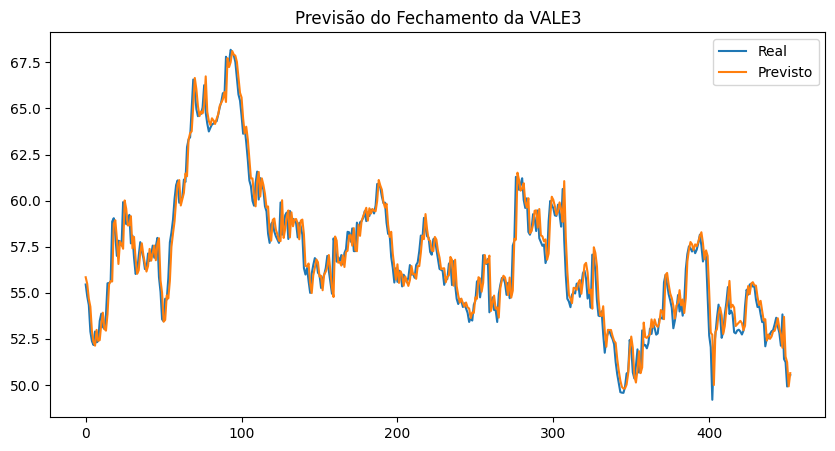

In [ ]:
## 10. Gráfico

plt.figure(figsize=(10,5))
plt.plot(y_real, label='Real')
plt.plot(pred_real, label='Previsto')
plt.legend()
plt.title('Previsão do Fechamento da VALE3')
plt.show()

In [ ]:
## 11. Tempo Final de Compilação
_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 9288.34 segundos
